In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Reading data from kaggle 

In [3]:
df=pd.read_csv('labeled_data.csv')

In [4]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


### Deleting columns which we didn't need and changing class to user identified labels

In [5]:
for index,row in df.iterrows():
    if row['class']==0:
        df.loc[index,'label']='hate'       
    elif row['class']==1:
        df.loc[index,'label']='offensive'
    elif row['class']==2:
        df.loc[index,'label']='neither'

In [6]:
df.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither','class'],axis=1,inplace=True)

In [7]:
df

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive
24779,"you've gone and broke the wrong heart baby, an...",neither
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive
24781,youu got wild bitches tellin you lies,offensive


In [8]:
df['label'].value_counts()

offensive    19190
neither       4163
hate          1430
Name: label, dtype: int64

### Importing fast AI

In [9]:
from fastai.text.all import *

## As we are using transfer learning in NLP and using ULMFIT method first we have to make our language model which would be trained on pre trained wikipedia model

In [10]:
df_text=df['tweet']

In [11]:
df_text=df_text.to_frame()

## Creating DataBlock 

In [12]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('tweet', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1) 
    # using only 10% of entire comments data for validation inorder to learn more
)

### Creating DataLoaders

In [13]:
dls_lm = dls_lm.dataloaders(df_text, bs=64, seq_len=72)


### As it is a language model it will predict the next sentence

In [14]:
dls_lm.show_batch(max_n=3)


,text,text_
0,xxbos xxmaj only keep real bitches in xxunk 👭 💁 xxbos xxup rt @tibaburger : xxmaj sick ass goal # ned # worldcup2014 xxbos xxunk xxmaj nevermind . xxmaj still a little bitch . http : / / t.co / xxunk xxbos xxup rt xxunk : xxup pm : xxmaj last night this xxunk was xxunk into the murder of a father traveling w / his family to celebrate the first nig,xxmaj only keep real bitches in xxunk 👭 💁 xxbos xxup rt @tibaburger : xxmaj sick ass goal # ned # worldcup2014 xxbos xxunk xxmaj nevermind . xxmaj still a little bitch . http : / / t.co / xxunk xxbos xxup rt xxunk : xxup pm : xxmaj last night this xxunk was xxunk into the murder of a father traveling w / his family to celebrate the first nig …
1,at someone 's place for free the least you could do is help keep it clean # ratchet # lazy # hoe xxbos i love bad bitches that s my fucking problem xxbos xxmaj like god damn you dirty bitch xxbos @erinscafe xxmaj bu i do . i do hate the playa . xxmaj and the xxmaj yankees . xxmaj if i hate the xxmaj yankees for their xxunk i have to,someone 's place for free the least you could do is help keep it clean # ratchet # lazy # hoe xxbos i love bad bitches that s my fucking problem xxbos xxmaj like god damn you dirty bitch xxbos @erinscafe xxmaj bu i do . i do hate the playa . xxmaj and the xxmaj yankees . xxmaj if i hate the xxmaj yankees for their xxunk i have to hate
2,"bitches 😁 xxbos @delaney_guinan you did a good job doing that to me and not texting back faggot xxbos xxmaj gabby is back bitches step aside xxbos xxup rt @idntwearcondoms : xxmaj if your girl see that another girl likes you , her name is "" this bitch "" until further notice . xxbos "" we hate niggers , we hate faggots and we hate xxunk xxrep 3 k rally xxbos trust","😁 xxbos @delaney_guinan you did a good job doing that to me and not texting back faggot xxbos xxmaj gabby is back bitches step aside xxbos xxup rt @idntwearcondoms : xxmaj if your girl see that another girl likes you , her name is "" this bitch "" until further notice . xxbos "" we hate niggers , we hate faggots and we hate xxunk xxrep 3 k rally xxbos trust me"


In [15]:

learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity()]).to_fp16()

### Determining the best learning rate as in Leslie Smith paper

SuggestedLRs(valley=0.005248074419796467)

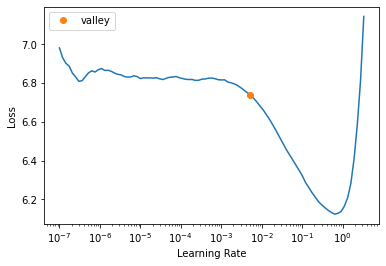

In [16]:
learn.lr_find()


In [17]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.846530,4.396165,0.260247,81.139091,01:39


In [18]:
learn.save('1epoch')


Path('models/1epoch.pth')

SuggestedLRs(valley=0.0063095735386013985)

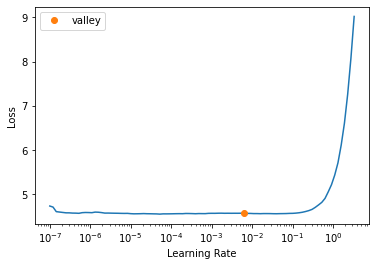

In [19]:
learn.lr_find()


In [20]:
learn.unfreeze()
learn.fit_one_cycle(10,lr_max=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.465878,4.270449,0.272953,71.553764,02:11
1,4.302573,4.130999,0.284397,62.240074,02:13
2,4.126461,4.050247,0.293500,57.411621,02:15
3,3.970782,4.013947,0.298550,55.364941,02:17
4,3.856567,4.002492,0.298853,54.734375,02:16
5,3.728352,3.999432,0.301953,54.567165,02:18
6,3.637755,3.993785,0.304427,54.259869,02:19
7,3.552158,3.997738,0.304818,54.474770,02:25
8,3.495354,3.999836,0.306084,54.589207,02:30
9,3.461251,4.001151,0.306482,54.661007,02:32


### The language model is 30 % accurate. Lets save our encoder

In [21]:
learn.save_encoder('finetuned')


## Let's predict some tweets

In [22]:
TEXT = "i"
N_WORDS = 10
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]


In [23]:
print("\n".join(preds))


i think it 's how you can show a bitch that
i have a bad bitch , i m lowkey free


## The data is heavily biased towards offensive tweets. Hence we randomly take 3000 tweets from each category

In [24]:
df['label'].value_counts()

offensive    19190
neither       4163
hate          1430
Name: label, dtype: int64

In [25]:
df_offensive = df[df.label== 'offensive']
df_hate = df[df.label== 'hate']
df_neither=df[df.label=='neither']

In [26]:
rows1 = np.random.choice(df_offensive.index.values, 1000)
rows2 = np.random.choice(df_hate.index.values, 1000)
rows3 = np.random.choice(df_neither.index.values, 1000)



In [27]:
df_offensive = df_offensive.loc[rows1]
df_hate = df_hate.loc[rows2]
df_neither=df_neither.loc[rows3]

In [28]:
li=[df_hate,df_offensive,df_neither]
df_new=pd.concat(li)
df_new

,tweet,label
17445,"RT @SteveStfler: ur a faggot if you change your name to your bday just so you can get bday tweets. this aint FB nigga, fuck yo birthday",hate
6091,@heyrmbr probs that fag Vhia,hate
22153,This time a night dark skin niggas really turn into lightskin niggas I swear I seen a darkie try buying Starbucks 3mins ago but they closed,hate
3407,@HuffingtonPost if the faggots can have a page y cant they?faggots offend me more than them,hate
5511,@alyssawiens faggot,hate
...,...,...
17264,"RT @Shakestweetz: Friends of @philbarron: @javachik has let me know that Phil is very ill. His infection has gone septic, and he is fightin&#8230;",neither
16114,RT @LJSpagnoli: Isis and Jihadi Terrorists 'Post 90 Tweets Every Minute' to Spread Propaganda http://t.co/eRJMveF996,neither
1968,&#9733; BEST ASIAN MASSAGE ON THE Brooklyn Park slope --TOP RATED SPA &#9733;718-622-0221 - 24 http://t.co/saWpjDtIGN,neither
4593,@RylannWilliams ok chill love bird lol,neither


## Creating Dataloaders for Classification

In [29]:
dls = TextDataLoaders.from_df(df_new, text_col='tweet', label_col='label',valid_pct=0.1,text_vocab=dls_lm.vocab)


In [30]:
dls.show_batch(max_n=3)


,text,category
0,xxbos xxup rt xxunk : xxmaj d - xxunk \n xxmaj e - xxunk 's \n xxmaj m - xxunk & & \n xxmaj o - xxunk \n xxmaj c - xxunk be \n xxmaj r - xxunk \n xxmaj a - mong \n xxmaj t - xxunk \n xxmaj s - xxunk,neither
1,xxbos xxup rt xxunk : xxunk \n 1 ) xxmaj we are not the xxmaj cubs \n 2 ) xxmaj we are not the xxmaj pirates \n 3 ) xxmaj we damn sure ai n't no f xxrep 3 * ing xxmaj cardinals . \n\n xxmaj who cares abo …,offensive
2,xxbos xxup diversity : xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk w / xxmaj xxunk xxmaj threats xxmaj xxunk xxmaj xxunk xxmaj of xxup gop xxmaj candidate : “ u xxmaj sellout xxmaj uncle xxmaj tom xxmaj ass xxmaj xxunk ” http : / / t.co / xxunk,hate


# Creating our learner 

In [31]:
learn = text_classifier_learner(dls,AWD_LSTM,metrics=accuracy,
                                drop_mult=0.5).to_fp16()


In [32]:
learn = learn.load_encoder('finetuned')


SuggestedLRs(valley=0.0012022644514217973)

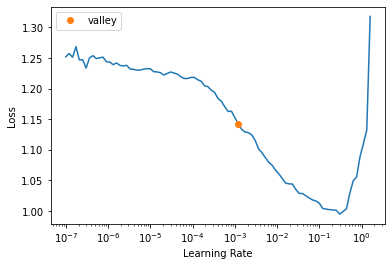

In [33]:
learn.lr_find()

# Using Discriminative training technique

In [34]:
learn.fit_one_cycle(1,2e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.907442,0.767067,0.653333,00:05


In [35]:
learn.freeze_to(-2)
# learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.801563,0.716953,0.683333,00:06


In [36]:
learn.freeze_to(-3)
# learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.702724,0.638538,0.746667,00:10


In [37]:

learn.unfreeze()
# learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.563322,0.516053,0.786667,00:14
1,0.474170,0.501195,0.803333,00:15
2,0.325939,0.451007,0.850000,00:15
3,0.210689,0.451829,0.850000,00:15
4,0.145419,0.442970,0.856667,00:15


# The model predicts each of the classification at more than 80% of times

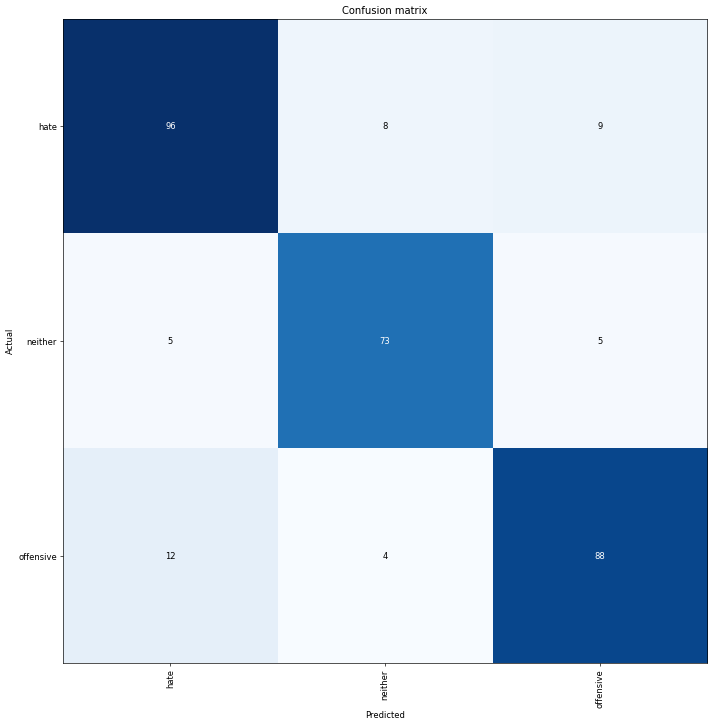

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Lets predict some made up tweets

In [39]:
pr=learn.predict('lets have lunch')

In [40]:
pr

('neither', TensorText(1), TensorText([0.0069, 0.9771, 0.0160]))

In [41]:
pr=learn.predict('die you mad person')

In [42]:
pr

('hate', TensorText(0), TensorText([0.7691, 0.0237, 0.2073]))

In [ ]:
pr=learn.predict('burn the grounds')

In [ ]:
pr

In [43]:
pr=learn.predict('burn the grounds')

In [44]:
pr

('hate', TensorText(0), TensorText([0.8288, 0.0349, 0.1362]))